# Abstract

This notebook implements models that can predict payprice based on the training data. Instead of using a constant base_bid when we predict the bidprice we can train regression models that use the predicted payprice as base_bid. We try five different models namely: Lasso, Ridge, ElasticNet, Random Forest Regressor and XGBoost Regressor.

# Import and Basic Info

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import random

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

# Set a random seed for repeatability
rand_seed = 123
random.seed(rand_seed)
np.random.seed(rand_seed)

In [2]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")

In [3]:
train.shape, validation.shape

((2430981, 25), (303925, 25))

## Import dummy datasets

In [4]:
from sklearn.externals import joblib

X = joblib.load("X_train_resampled_basebid.pkl")
y = joblib.load("y_train_resampled_basebid.pkl")
X_validation = joblib.load("X_validation_basebid.pkl")
y_validation = joblib.load("y_validation_basebid.pkl")

In [5]:
X.shape, y.shape, X_validation.shape, y_validation.shape

((41793, 698), (41793,), (303925, 698), (303925,))

In [6]:
feature_columns_total = joblib.load("total_features_basebid.pkl")

In [7]:
len(feature_columns_total)

698

## Feature Selection 

In [8]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, make_scorer

In [9]:
def neg_rmse(y, y_pred):
    
    return -np.sqrt(mean_squared_error(y, y_pred))

neg_rmse_scorer = make_scorer(neg_rmse)

In [10]:
clf_name = ["Lasso", "Ridge", "ElasticNet"]
clf = [Lasso(random_state = rand_seed), 
       Ridge(random_state = rand_seed),
       ElasticNet(random_state = rand_seed)]

CPU times: user 8min 40s, sys: 56.5 s, total: 9min 37s
Wall time: 1min 48s
Optimal number of features for Lasso is 8
CPU times: user 6min 33s, sys: 52.1 s, total: 7min 25s
Wall time: 1min 24s
Optimal number of features for Ridge is 468
CPU times: user 7min 13s, sys: 57.8 s, total: 8min 11s
Wall time: 1min 39s
Optimal number of features for ElasticNet is 58


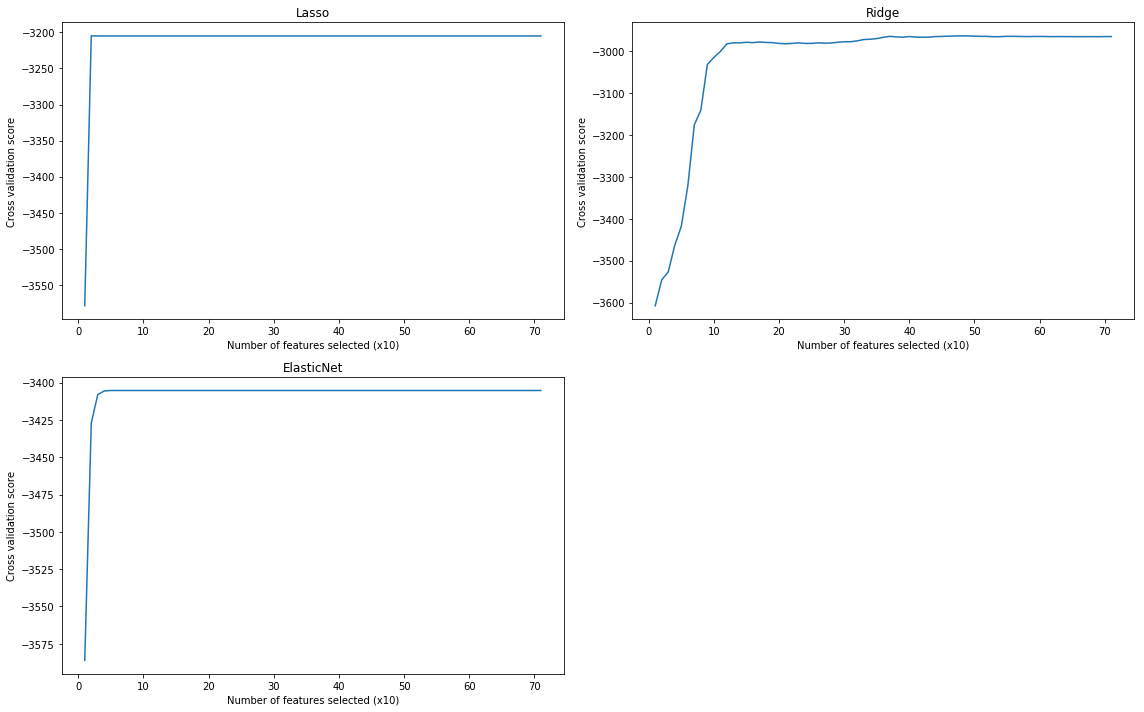

In [11]:
features_selected =  dict.fromkeys(clf_name)

plt.figure(figsize = (16,10))

for i in range(len(clf)):
    
    model = clf[i]
    
    # Initialize Recursive Feature Elimination object
    stepsize = 10
    rfecv = RFECV(estimator = model, step = stepsize, cv = StratifiedKFold(n_splits = 2), 
                  scoring = "neg_mean_squared_error")
    
    # Fit 
    % time rfecv.fit(X, y)
    
    # Number of important features
    print("Optimal number of features for {} is {}".format(clf_name[i], rfecv.n_features_))
    
    # Plot number of features VS. cross-validation scores
    plt.subplot(2,2,i+1)
    plt.xlabel("Number of features selected (x{})".format(stepsize))
    plt.ylabel("Cross validation score")
    plt.title(clf_name[i])
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    
    # Store feature importance to dict
    #feature_importance[i] = sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), train_dummy_2.columns))
    features_selected[clf_name[i]] = [f for f, s in zip(feature_columns_total, rfecv.support_) if s]
    
    # Export to pickle
    names = ["Lasso-Features.pkl", "Ridge-Features.pkl", "Elastic-Features.pkl"]
    joblib.dump(features_selected[clf_name[i]], names[i])
    
plt.tight_layout()

### Hyperparameter Tuning

In [12]:
lasso_grid = {"alpha": [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100]}


ridge_grid = {"alpha": [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100]}


elastic_grid = {"alpha": [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100],
                "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.85]}

In [13]:
def TuneHyperparameters(estimator, grid, features, name_store):
    
    # Data preparation
    X_train = pd.DataFrame(columns = feature_columns_total, data = X)[features].values
    y_train = y
    
    X_val = pd.DataFrame(columns = feature_columns_total, data = X_validation)[features].values
    y_val = y_validation
    
    # Define grid
    grid = GridSearchCV(estimator, 
                        param_grid = grid, 
                        scoring = "neg_mean_squared_error", 
                        cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = rand_seed))

    # Fit grid on train data
    % time grid.fit(X_train, y_train)

    # Store best model
    best_model = grid.best_estimator_
    joblib.dump(best_model, name_store) 
    print("Best parameters: {}".format(grid.best_params_))

    # Predict on validation set
    preds = grid.predict(X_val)
    
    # Evaluate performance
    print("\n")
    print("RMSE:")
    print(neg_rmse(y_val, preds))
    print("\n")
    
    # Store probabilities
    submission = pd.DataFrame(data = list(zip(validation["bidid"], preds, validation["payprice"])),
                               columns = ["bidid", "predicted_payprice", "payprice"])
    
    return best_model, submission

In [14]:
lasso_best_model, lasso_sub = TuneHyperparameters(Lasso(random_state = rand_seed),
                                                  lasso_grid,
                                                  features_selected["Lasso"],
                                                  "Lasso-BestModel.pkl")

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


CPU times: user 1.79 s, sys: 88 ms, total: 1.88 s
Wall time: 354 ms
Best parameters: {'alpha': 0.05}


RMSE:
-55.767496335006136




### Ridge

In [15]:
ridge_best_model, ridge_sub = TuneHyperparameters(Ridge(random_state = rand_seed),
                                                  ridge_grid,
                                                  features_selected["Ridge"],
                                                  "Ridge-BestModel.pkl")

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


CPU times: user 1min 39s, sys: 20.8 s, total: 2min
Wall time: 30.1 s
Best parameters: {'alpha': 15}


RMSE:
-53.81149538549817




### Elastic Net

In [16]:
elastic_best_model, elastic_subb = TuneHyperparameters(ElasticNet(random_state = rand_seed),
                                                       elastic_grid,
                                                       features_selected["ElasticNet"],
                                                       "ElasticNet-BestModel.pkl")

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


CPU times: user 1min 4s, sys: 3.38 s, total: 1min 7s
Wall time: 8.66 s
Best parameters: {'alpha': 0.05, 'l1_ratio': 0.85}


RMSE:
-54.85502433502128




### Random Forest Regressor

In [17]:
def FeatureSelection(estimator, name_store):
    
    % time estimator.fit(X,y)
    
    features = pd.DataFrame(list(zip(feature_columns_total,estimator.feature_importances_)), 
                               columns = ["Feature", "Importance"] )
    
    #best_features = features.sort_values(by = 'Importance', ascending = False)["Feature"].values
    
    # Store results
    joblib.dump(features, name_store) 
    
    return features


def FitAndEvaluate(estimator, features, name_store):
    
    # Data preparation
    X_train = pd.DataFrame(columns = feature_columns_total, data = X)[features].values
    y_train = y
    
    X_val = pd.DataFrame(columns = feature_columns_total, data = X_validation)[features].values
    y_val = y_validation
    
    # Fit classifier to training data
    % time estimator.fit(X_train, y_train)
    
    # Store results
    joblib.dump(estimator, name_store) 
    
    # Predict on validation set
    preds = estimator.predict(X_val)
    
    # Evaluate performance
    print("\n")
    print("RMSE:")
    print(neg_rmse(y_val, preds))
    print("\n")
    
    # Store probabilities
    submission = pd.DataFrame(data = list(zip(validation["bidid"], preds)),
                               columns = ["bidid", "predicted_payprice"])
    
    return submission

In [18]:
rfg_model = RandomForestRegressor(n_estimators = 500, max_depth = 30, random_state = rand_seed)

In [19]:
rfg_features = FeatureSelection(rfg_model, "RFG-Features.pkl").sort_values(by = 'Importance', ascending = False)["Feature"].values

CPU times: user 17min 4s, sys: 364 ms, total: 17min 4s
Wall time: 17min 4s


In [20]:
rfg_sub = FitAndEvaluate(rfg_model, rfg_features[:20], "RFG-BestModel.pkl")

CPU times: user 27.8 s, sys: 4 ms, total: 27.8 s
Wall time: 27.8 s


RMSE:
-53.990201077163654




### XGBRegressor

In [21]:
xgb_model = XGBRegressor(n_estimators = 500, max_depth = 8, learning_rate = 0.1, random_state = rand_seed)

In [22]:
xgb_features = FeatureSelection(xgb_model, "XGBR-Features.pkl").sort_values(by = 'Importance', ascending = False)["Feature"].values

CPU times: user 9min 42s, sys: 556 ms, total: 9min 43s
Wall time: 9min 43s


In [23]:
xgbreg_sub = FitAndEvaluate(xgb_model, xgb_features[:40], "XGBR-BestModel.pkl")

CPU times: user 45.6 s, sys: 60 ms, total: 45.6 s
Wall time: 45.6 s


RMSE:
-53.504870813511715




### Store Results

In [24]:
lasso_sub.to_csv("Prediction_csv/lasso_basebid.csv")
ridge_sub.to_csv("Prediction_csv/ridge_basebid.csv")
elastic_subb.to_csv("Prediction_csv/elasticnet_basebid.csv")
rfg_sub.to_csv("Prediction_csv/rfg_basebid.csv")
xgbreg_sub.to_csv("Prediction_csv/xgb_basebid.csv")